In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tarfile
import urllib
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import PIL
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv("G:/Datasets/housing.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

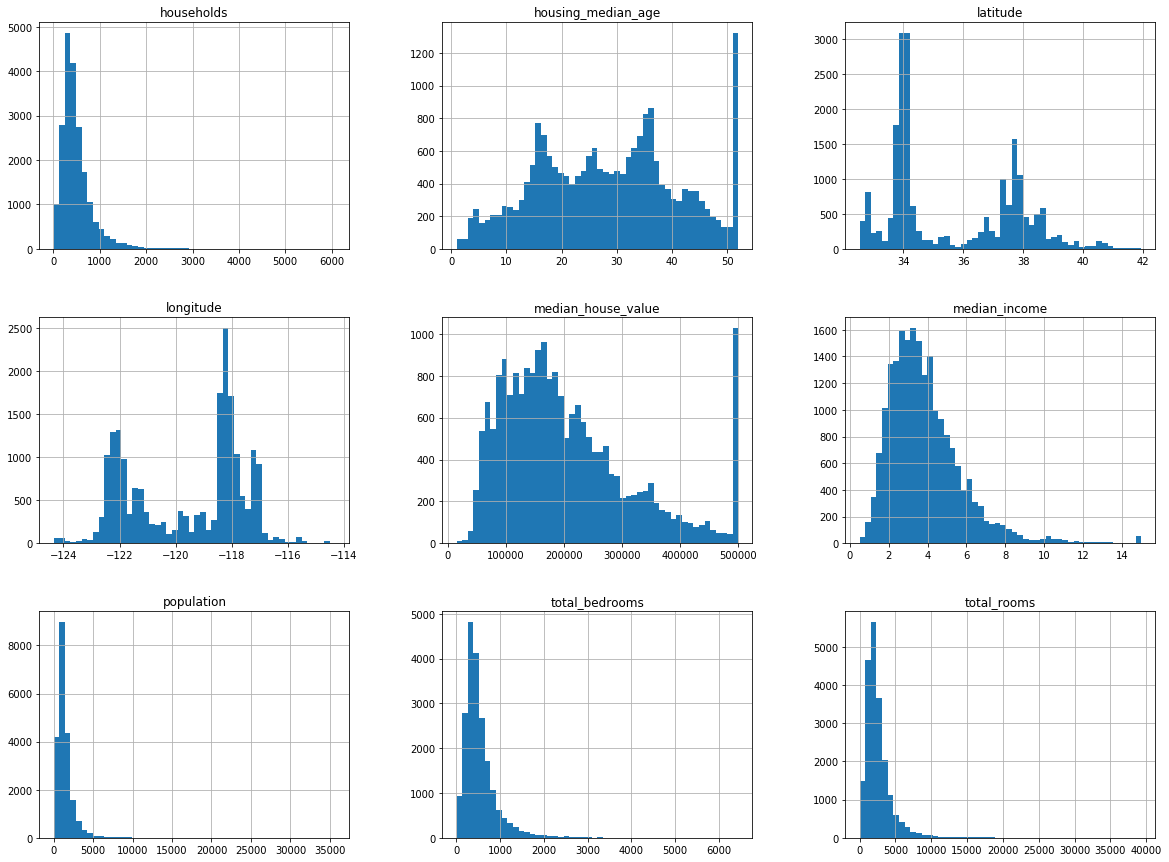

In [6]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(df, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [9]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [10]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
df_with_id = df.reset_index()
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

In [12]:
df_with_id["id"] = df["longitude"] * 1000 + df["latitude"]
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "id")

In [13]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

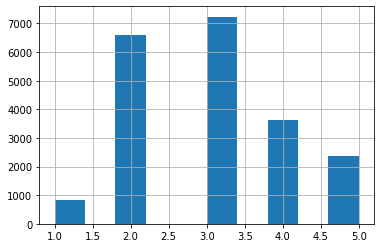

In [14]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
df["income_cat"].hist()

In [15]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [18]:
df = strat_train_set.copy()

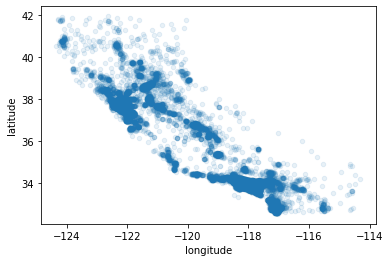

In [19]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

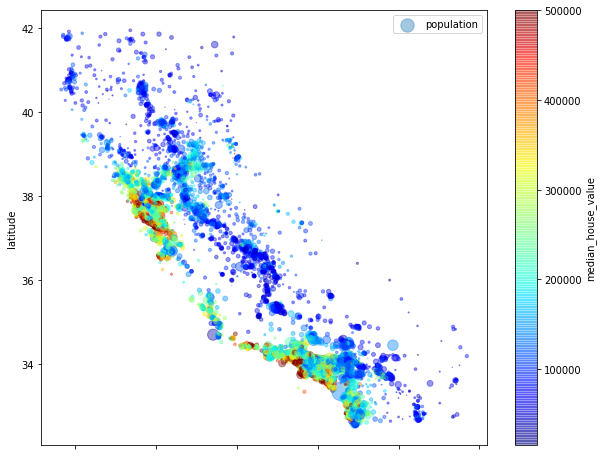

In [20]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
       s=df["population"]/100, label="population", figsize=(10,8),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
       )
plt.legend()

In [21]:
corr_matrix = df.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [23]:
corr_matrix["population"].sort_values(ascending=False)

population            1.000000
households            0.904637
total_bedrooms        0.876320
total_rooms           0.855109
longitude             0.108030
median_income         0.002380
median_house_value   -0.026920
latitude             -0.115222
housing_median_age   -0.298710
Name: population, dtype: float64

In [24]:
corr_matrix["median_income"].sort_values(ascending=False)

median_income         1.000000
median_house_value    0.687160
total_rooms           0.200087
households            0.010781
population            0.002380
total_bedrooms       -0.009740
longitude            -0.019583
latitude             -0.075205
housing_median_age   -0.111360
Name: median_income, dtype: float64

In [25]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000239490092E8>,
      dtype=object)

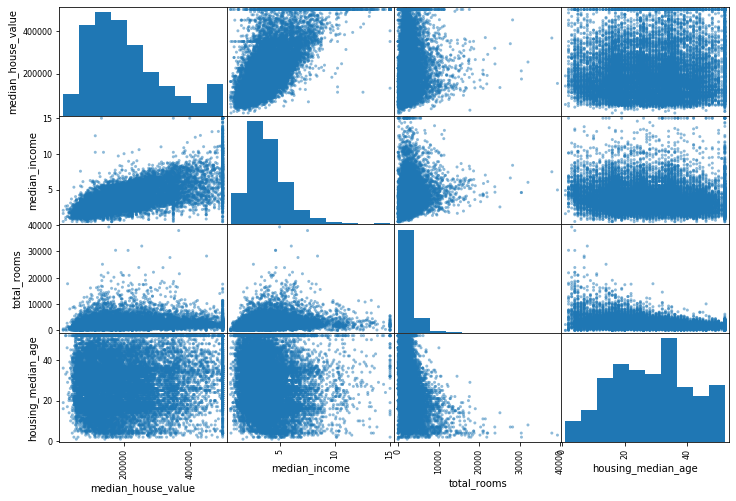

In [26]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df[attributes], figsize=(12, 8))

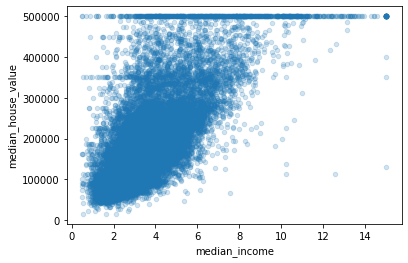

In [27]:
df.plot(kind="scatter", x="median_income", y="median_house_value", alpha = 0.2)

In [28]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_rooms"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_house"] = df["population"]/df["households"]

In [29]:
corr_matrix = df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687160
rooms_per_household     0.146285
total_rooms             0.135097
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
population_per_house   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
bedrooms_per_rooms     -0.259984
Name: median_house_value, dtype: float64

In [30]:
df = strat_train_set.drop("median_house_value", axis=1)
df_labels = strat_train_set["median_house_value"].copy()

In [31]:
median = df["total_bedrooms"].median()
df["total_bedrooms"].fillna(median, inplace=True)

In [32]:
from sklearn.impute import SimpleImputer

In [33]:
imputer = SimpleImputer(strategy = "median")
df_num = df.drop("ocean_proximity", axis=1)

In [34]:
imputer.fit(df_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
df_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
X = imputer.transform(df_num)

In [38]:
df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)

In [39]:
df_cat = df[["ocean_proximity"]]
df_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [40]:
from sklearn.preprocessing import OrdinalEncoder

In [41]:
ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
df_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
df_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [46]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(df.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
df_extra_attribs = attr_adder.transform(df.values)
    

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [48]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),
                       ])

df_num_tr = num_pipeline.fit_transform(df_num)

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                            ("num", num_pipeline, num_attribs),
                            ("cat", OneHotEncoder(), cat_attribs), 
      ])
df_prepared = full_pipeline.fit_transform(df)

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_prepared, df_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
some_data = df.iloc[:5]
some_lables = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("prediction", lin_reg.predict(some_data_prepared))

prediction [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [52]:
print("labels", list(some_lables))

labels [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [53]:
from sklearn.metrics import mean_squared_error
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_labels, df_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [54]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [55]:
df_prediction = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

68628.19819848922

In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rsme_scores = np.sqrt(-scores)

In [57]:
def display_score(scores):
    print("scores:", scores)
    print("mean:", scores.mean())
    print("stadard deviation:", scores.std())
display_score(tree_rsme_scores)

scores: [68487.64595326 67104.791282   70798.73528635 67752.51150013
 71369.51467961 74969.47055221 71145.16111961 72073.25582272
 75125.99216819 68541.92751461]
mean: 70736.90058786927
stadard deviation: 2674.157230575899


In [58]:
lin_scores = cross_val_score(lin_reg, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_score(lin_rmse_scores)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean: 69052.46136345083
stadard deviation: 2731.674001798347


In [59]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(df_prepared, df_labels)


C:\Users\waqqas\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [60]:
df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22185.53940552526

In [61]:
forest_score = cross_val_score(forest_reg, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
forest_reg_score = np.sqrt(-forest_score)
display_score(forest_reg_score)

scores: [51797.15447534 49936.54500871 52466.84471777 53957.08599939
 51660.10657787 55654.6092207  50525.4701911  51523.55311439
 55774.29389765 52607.30659987]
mean: 52590.29698027837
stadard deviation: 1880.1507592976404
